In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from afinn import Afinn
from nrclex import NRCLex
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pyttsx3

In [2]:
!pip install SpeechRecognition wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 50.1 MB/s eta 0:00:00


In [3]:
!pip install afinn nrclex pyttsx3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53431 sha256=b438932fd8d4c61c091005f8bdcefc0c773df28013cfc2fa382cf07fde7ed430
  Stored in directory: /root/.cache/pip/wheels/ee/d3/a0/f9255ebac29886acb1c28b35b37523f6399677fa06be379f25
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=d2797b64ff8f948590f4b6b730c77de9e13f39fda0b136806ca12db203f6a6d7
  Stored in directory: /root/.cache/pip/wheels/ed/ac/fa/7afddefd14f51c4a963ed291b9052746ed3929473e5a33118d
Successfully built afinn nrclex


In [5]:
import speech_recognition as sr

In [6]:
nltk.download('stopwords')
nltk.download('opinion_lexicon')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [7]:
df = pd.read_csv("/content/drive/MyDrive/DATASETS/Covid_tweet.csv")
df.dropna(subset=['text'], inplace=True)
df['clean_text'] = df['text'].str.lower()
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'http\\S+|www\\S+|[^a-z ]', "", x))
stop_words = set(stopwords.words('english'))
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
print(df.shape)
df.head()

(179108, 14)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,26-05-2017 05:46,624,950,18775,False,25-07-2020 12:27,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,smelled scent hand sanitizers today someone pa...
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",16-04-2009 20:06,2253,1677,24,True,25-07-2020 12:27,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,hey yankees yankeespr mlb wouldnt made sense p...
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,28-02-2009 18:57,9275,9525,7254,False,25-07-2020 12:27,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,diane wdunlap realdonaldtrump trump never clai...
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,07-03-2019 01:45,197,987,1488,False,25-07-2020 12:27,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,brookbanktv one gift covid give appreciation s...
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,12-02-2017 06:45,101009,168,101,False,25-07-2020 12:27,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,july media bulletin novel coronavirusupdates c...


In [8]:
nltk.download('punkt_tab')
from nltk.corpus import opinion_lexicon
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())
def get_bing_score(text):
  words = word_tokenize(text)
  return sum([1 for word in words if word in pos_words]) - sum([1 for word in words if word in neg_words])
df['bing_score'] = df['clean_text'].apply(get_bing_score)
af = Afinn()
df['afinn_score'] = df['clean_text'].apply(af.score)
df['nrc_scores'] = df['clean_text'].apply(lambda x: NRCLex(x).raw_emotion_scores)
df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,bing_score,afinn_score,nrc_scores
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,26-05-2017 05:46,624,950,18775,False,25-07-2020 12:27,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,smelled scent hand sanitizers today someone pa...,-1,0.0,"{'disgust': 1, 'negative': 1}"
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",16-04-2009 20:06,2253,1677,24,True,25-07-2020 12:27,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,hey yankees yankeespr mlb wouldnt made sense p...,0,1.0,"{'positive': 3, 'anticipation': 1, 'joy': 1, '..."
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,28-02-2009 18:57,9275,9525,7254,False,25-07-2020 12:27,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,diane wdunlap realdonaldtrump trump never clai...,0,-2.0,"{'surprise': 2, 'anger': 1, 'disgust': 1, 'neg..."
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,07-03-2019 01:45,197,987,1488,False,25-07-2020 12:27,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,brookbanktv one gift covid give appreciation s...,0,4.0,"{'anticipation': 1, 'joy': 2, 'positive': 2, '..."
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,12-02-2017 06:45,101009,168,101,False,25-07-2020 12:27,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,july media bulletin novel coronavirusupdates c...,0,2.0,{}


In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
count_vectorizer = CountVectorizer(max_features=500, stop_words='english')
X_counts = count_vectorizer.fit_transform(df['clean_text']).toarray()
vocab = count_vectorizer.get_feature_names_out()
co_occurrence = np.dot(X_counts.T, X_counts)
svd = TruncatedSVD(n_components=50, random_state=42)
glove_embeddings = svd.fit_transform(co_occurrence)

In [10]:
word2index = {w: i for i, w in enumerate(vocab)}
def avg_embed(text):
  tokens = [w for w in text.split() if w in word2index]
  if not tokens: return np.zeros(50)
  idxs = [word2index[w] for w in tokens]
  return glove_embeddings[idxs].mean(axis=0)
df['glove_embed'] = df['clean_text'].apply(avg_embed)
glove_matrix = np.stack(df['glove_embed'].values)
glove_matrix

array([[ 1.19792984e+03,  3.70604398e+02, -1.56268598e+02, ...,
         5.68459805e+01,  7.72174823e+00, -1.66945504e+01],
       [ 2.81638001e+02, -4.65636537e+01, -1.26874936e+01, ...,
         1.10048868e+01,  1.40740729e+00,  7.14091991e-01],
       [ 4.39520904e+04, -2.67475732e+03, -2.26808080e+02, ...,
        -1.17209997e+01,  2.54109320e+01, -6.01931288e+01],
       ...,
       [ 6.47551732e+04, -3.82460560e+03, -3.73402121e+02, ...,
        -2.82817827e+01, -1.91586581e+02,  1.35926595e+02],
       [ 1.97875848e+04, -8.72745648e+02, -4.80049391e+01, ...,
         6.32255554e+01, -3.02238813e+00, -1.04438093e+02],
       [ 9.53041106e+02, -1.78765522e+02, -4.19517982e+01, ...,
         1.21162202e+02, -8.84659319e+00, -9.75660910e+01]])

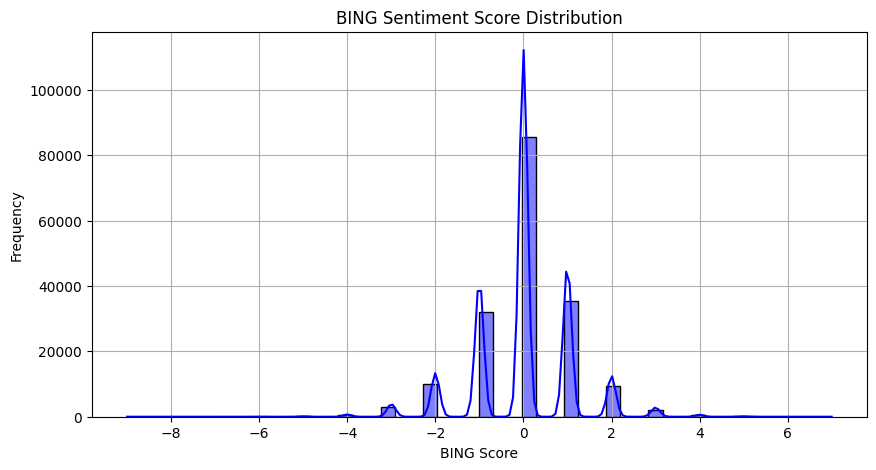

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(df['bing_score'], bins=50, kde=True, color='blue')
plt.title("BING Sentiment Score Distribution")
plt.xlabel("BING Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

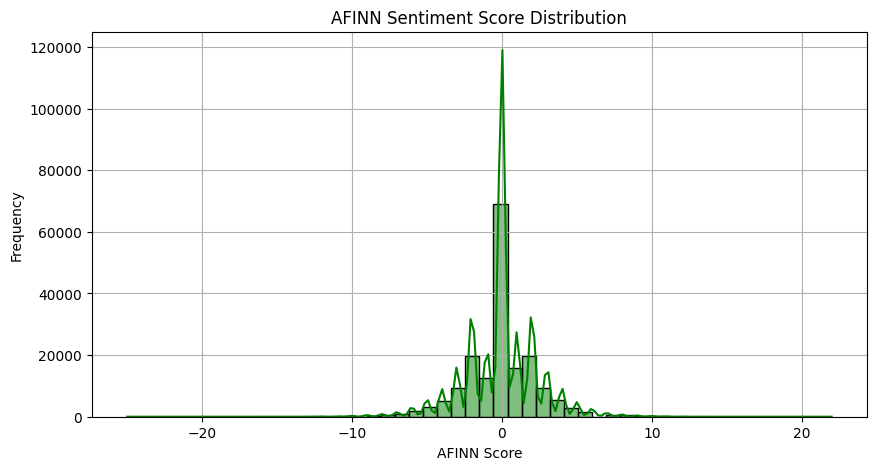

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(df['afinn_score'], bins=50, kde=True, color='green')
plt.title("AFINN Sentiment Score Distribution")
plt.xlabel("AFINN Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

/tmp/ipython-input-13-991175396.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emotion_df, x='Emotion', y='Frequency', palette='coolwarm')


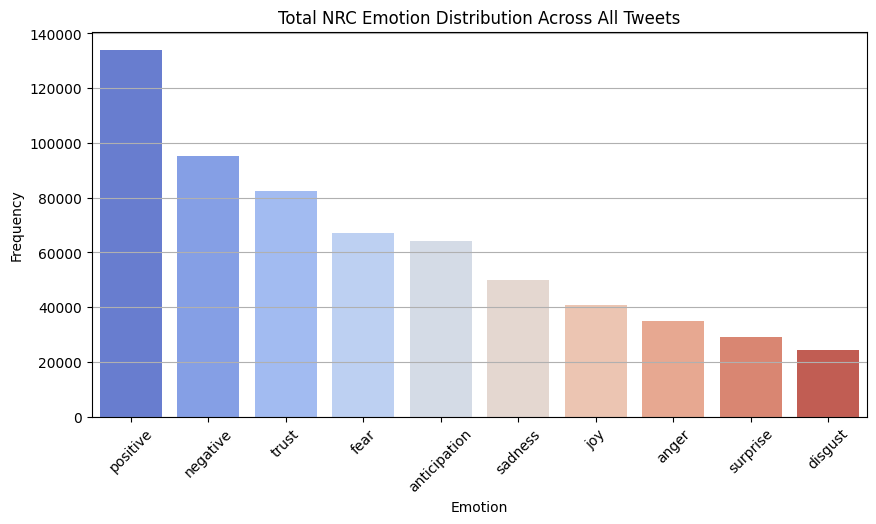

In [13]:
from collections import defaultdict
emotion_totals = defaultdict(int)
for score_dict in df['nrc_scores']:
    for emotion, value in score_dict.items():
        emotion_totals[emotion] += value
emotion_df = pd.DataFrame(emotion_totals.items(), columns=['Emotion', 'Frequency'])
emotion_df = emotion_df.sort_values(by='Frequency', ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=emotion_df, x='Emotion', y='Frequency', palette='coolwarm')
plt.title("Total NRC Emotion Distribution Across All Tweets")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


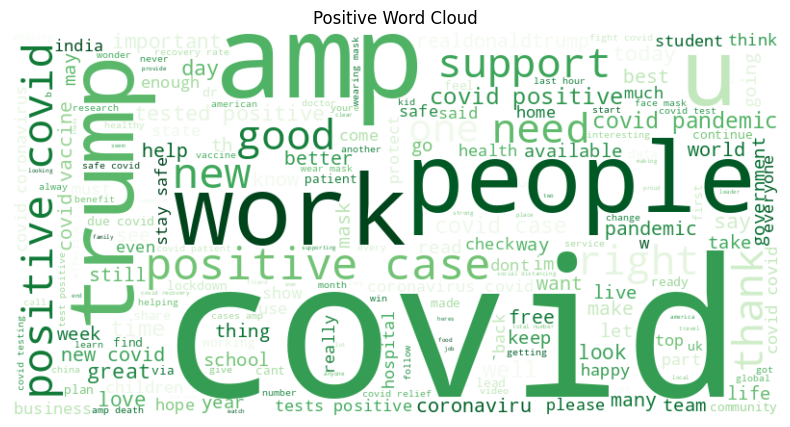

In [14]:
positive_text = " ".join(df[df['bing_score'] > 0]['clean_text'])
negative_text = " ".join(df[df['bing_score'] < 0]['clean_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Word Cloud")
plt.show()

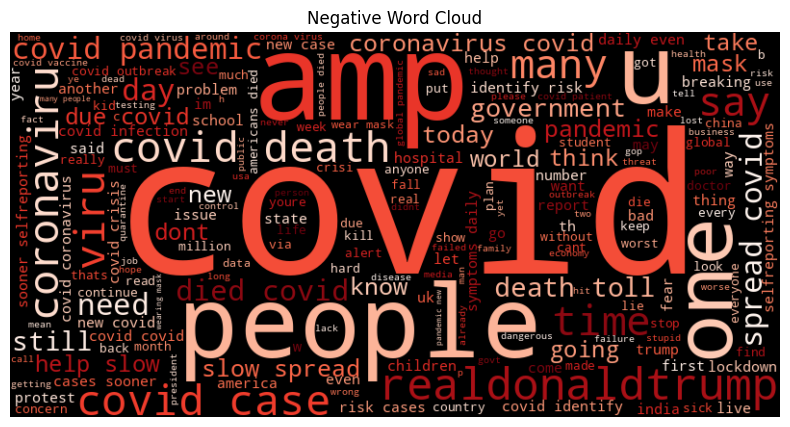

In [15]:
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Word Cloud")
plt.show()

In [16]:
sia = SentimentIntensityAnalyzer()
df['vader_score'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_label'] = df['vader_score'].apply(lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral'))
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,bing_score,afinn_score,nrc_scores,glove_embed,vader_score,sentiment_label
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,26-05-2017 05:46,624,950,18775,False,25-07-2020 12:27,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,smelled scent hand sanitizers today someone pa...,-1,0.0,"{'disgust': 1, 'negative': 1}","[1197.9298364508536, 370.6043976616612, -156.2...",0.4939,positive
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",16-04-2009 20:06,2253,1677,24,True,25-07-2020 12:27,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,hey yankees yankeespr mlb wouldnt made sense p...,0,1.0,"{'positive': 3, 'anticipation': 1, 'joy': 1, '...","[281.63800052087834, -46.56365365221185, -12.6...",0.2263,positive
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,28-02-2009 18:57,9275,9525,7254,False,25-07-2020 12:27,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,diane wdunlap realdonaldtrump trump never clai...,0,-2.0,"{'surprise': 2, 'anger': 1, 'disgust': 1, 'neg...","[43952.0904174487, -2674.7573210882033, -226.8...",0.2057,positive
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,07-03-2019 01:45,197,987,1488,False,25-07-2020 12:27,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,brookbanktv one gift covid give appreciation s...,0,4.0,"{'anticipation': 1, 'joy': 2, 'positive': 2, '...","[64264.5122822592, -3760.311071439364, -339.29...",0.7351,positive
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,12-02-2017 06:45,101009,168,101,False,25-07-2020 12:27,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,july media bulletin novel coronavirusupdates c...,0,2.0,{},"[43419.56010019041, -2321.2432864122034, -268....",0.3182,positive


In [17]:
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(glove_matrix, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(143286, 50) (35822, 50) (143286,) (35822,)


In [18]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Gradient Boosting": GradientBoostingClassifier()
}
print("\nEvaluating ML models...\n")
model_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_scores[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Evaluating ML models...


Decision Tree Accuracy: 0.5443
[[3597 3193 1940]
 [2291 9043 2772]
 [2128 4001 6857]]
              precision    recall  f1-score   support

    negative       0.45      0.41      0.43      8730
     neutral       0.56      0.64      0.60     14106
    positive       0.59      0.53      0.56     12986

    accuracy                           0.54     35822
   macro avg       0.53      0.53      0.53     35822
weighted avg       0.54      0.54      0.54     35822


Random Forest Accuracy: 0.5990
[[ 3354  3463  1913]
 [ 1349 10136  2621]
 [ 1096  3923  7967]]
              precision    recall  f1-score   support

    negative       0.58      0.38      0.46      8730
     neutral       0.58      0.72      0.64     14106
    positive       0.64      0.61      0.63     12986

    accuracy                           0.60     35822
   macro avg       0.60      0.57      0.58     35822
weighted avg       0.60      0.60      0.59     35822



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Accuracy: 0.5159
[[1887 4567 2276]
 [ 968 9742 3396]
 [ 750 5385 6851]]
              precision    recall  f1-score   support

    negative       0.52      0.22      0.31      8730
     neutral       0.49      0.69      0.58     14106
    positive       0.55      0.53      0.54     12986

    accuracy                           0.52     35822
   macro avg       0.52      0.48      0.47     35822
weighted avg       0.52      0.52      0.50     35822


Gradient Boosting Accuracy: 0.5487
[[ 2200  4375  2155]
 [  955 10311  2840]
 [  778  5063  7145]]
              precision    recall  f1-score   support

    negative       0.56      0.25      0.35      8730
     neutral       0.52      0.73      0.61     14106
    positive       0.59      0.55      0.57     12986

    accuracy                           0.55     35822
   macro avg       0.56      0.51      0.51     35822
weighted avg       0.56      0.55      0.53     35822



In [19]:
best_model_name = max(model_scores, key=model_scores.get)
print(f"\n✅ Best Model: {best_model_name}")
if best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }
    base_model = RandomForestClassifier()
elif best_model_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
    base_model = GradientBoostingClassifier()
elif best_model_name == "Logistic Regression":
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    }
    base_model = LogisticRegression(max_iter=500)
elif best_model_name == "Decision Tree":
    param_grid = {
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    base_model = DecisionTreeClassifier()
elif best_model_name == "Naive Bayes":
    param_grid = {
        'alpha': [0.1, 0.5, 1.0]
    }
    base_model = MultinomialNB()
grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
print(f"\n🔍 Best Parameters: {grid_search.best_params_}")
print("✅ Best Cross-Validated Accuracy:", grid_search.best_score_)


✅ Best Model: Random Forest
Fitting 3 folds for each of 12 candidates, totalling 36 fits

🔍 Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
✅ Best Cross-Validated Accuracy: 0.5918931368033165


In [20]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, vocab=None):
        self.labels = labels
        self.tokenized = [t.split() for t in texts]
        self.vocab = vocab if vocab else self.build_vocab(self.tokenized)
        self.encoded = [[self.vocab.get(w, self.vocab["<UNK>"]) for w in tweet] for tweet in self.tokenized]

    def build_vocab(self, texts):
        vocab = {"<PAD>": 0, "<UNK>": 1}
        for i, word in enumerate(set([w for t in texts for w in t]), 2):
            vocab[word] = i
        return vocab
    def __len__(self): return len(self.encoded)
    def __getitem__(self, idx): return torch.tensor(self.encoded[idx]), torch.tensor(self.labels[idx])

def collate_fn(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded, torch.tensor(labels)
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['sentiment_label'].map(label_map)
texts = df['clean_text'].tolist()
labels = df['label_id'].tolist()
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)
train_dataset = TweetDataset(train_texts, train_labels)
test_dataset = TweetDataset(test_texts, test_labels, vocab=train_dataset.vocab)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

In [21]:
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, output_dim=3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embed(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMSentiment(vocab_size=len(train_dataset.vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
for epoch in range(2):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 1517.0427
Epoch 2, Loss: 683.1697


In [23]:
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))
def ai_text_chatbot():
    print("🤖 Hello! I'm your COVID tweet sentiment bot.")
    print("Type 'exit' to stop chatting.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            print("🤖 Goodbye! Stay safe.")
            break
        cleaned = re.sub(r"http\S+|www\S+|[^a-z\s]", "", user_input.lower())
        cleaned = " ".join([w for w in cleaned.split() if w not in stop_words])
        score = sia.polarity_scores(cleaned)['compound']
        if score > 0.1:
            response = "That sounds positive 🙂"
        elif score < -0.1:
            response = "That sounds negative 🙁"
        else:
            response = "That seems neutral 😐"
        print("🤖 Bot:", response)
ai_text_chatbot()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


🤖 Hello! I'm your COVID tweet sentiment bot.
Type 'exit' to stop chatting.

You: Things are getting worse.
🤖 Bot: That sounds negative 🙁
You: hello
🤖 Bot: That seems neutral 😐
You: exit
🤖 Goodbye! Stay safe.


In [ ]:
import re
import nltk
import pyttsx3
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('vader_lexicon')

stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()
engine = pyttsx3.init()
engine.setProperty('rate', 150)

def ai_voice_chatbot_simulation(sample_input):
    print("🎤 Simulating voice input...")
    print("🗣️ You said:", sample_input)
    cleaned = re.sub(r"http\S+|www\S+|[^a-z\s]", "", sample_input.lower())
    cleaned = " ".join([w for w in cleaned.split() if w not in stop_words])
    score = sia.polarity_scores(cleaned)['compound']
    if score > 0.1:
        response = "That sounds positive 🙂"
    elif score < -0.1:
        response = "That sounds negative 🙁"
    else:
        response = "That seems neutral 😐"

    print("🤖 Bot:", response)
    engine.say(response)
    engine.runAndWait()

def ai_voice_chatbot():
    recognizer = sr.Recognizer()
    engine = pyttsx3.init()
    engine.setProperty('rate', 150)

    print("🎙️ Speak now...")

    with sr.Microphone() as source:
        audio = recognizer.listen(source)

    try:
        user_input = recognizer.recognize_google(audio)
        print("🗣️ You said:", user_input)
        ai_voice_chatbot_simulation(user_input)
    except sr.UnknownValueError:
        print("❌ Could not understand audio.")
        engine.say("Sorry, I couldn't understand.")
        engine.runAndWait()

ai_voice_chatbot()